In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_biclusters
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from scipy.spatial.transform import Rotation as R
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from scipy.stats import ks_2samp
import dill

### Create artificial dataset

In [34]:
data = make_classification(n_samples=2000, n_features=2, n_redundant=0, random_state=42)
X = data[0]
y = data[1]
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y
train, test = train_test_split(df, test_size=0.3, random_state=42)

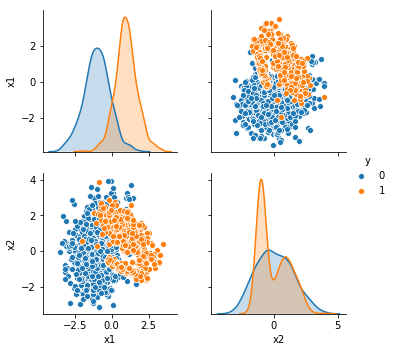

In [35]:
# plot
sns.pairplot(data=train, x_vars=['x1', 'x2'], y_vars=['x1', 'x2'], hue='y')

### create model pipe and cross val scores

In [36]:
# pipe
knn_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

In [37]:
scorers = ('accuracy', 'f1', 'roc_auc')

In [38]:
cross_validate(knn_pipe, X=train[['x1', 'x2']], y=train['y'], scoring=scorers, cv=3, return_train_score=False)

{'fit_time': array([0.00332475, 0.00297379, 0.00305915]),
 'score_time': array([0.0355258 , 0.03432465, 0.03428721]),
 'test_accuracy': array([0.93361884, 0.90364026, 0.89270386]),
 'test_f1': array([0.9321663, 0.9044586, 0.8940678]),
 'test_roc_auc': array([0.97214273, 0.95565034, 0.93367723])}

## ML Flow run

In [53]:
# create id
mlflow.create_experiment('neighbors')

'3'

In [54]:
for n_neighbours in range(1,20):
    mlflow.start_run(experiment_id=3)
    knn_pipe.set_params(**{'knn__n_neighbors': n_neighbours})
    scores = cross_validate(knn_pipe, X=train[['x1', 'x2']], y=train['y'],
                            scoring=scorers, cv=3, return_train_score=False)
    mlflow.log_param('n_neighbors', n_neighbours)
    mlflow.log_metric('f1_mean', scores['test_f1'].mean())
    mlflow.log_metric('accuracy_mean', scores['test_accuracy'].mean())
    mlflow.log_metric('roc_auc_mean', scores['test_roc_auc'].mean())
    knn_pipe.fit(X=train[['x1', 'x2']], y=train['y'],)
    mlflow.sklearn.log_model(knn_pipe, 'knn')
    mlflow.end_run()

In [55]:
%%bash
ls

ks_test.ipynb
ml_flow.ipynb
mlruns


In [56]:
%%bash
mlflow ui

Process is terminated.


### reload model

In [57]:
best_model = mlflow.sklearn.load_model("runs:/28032d5b664740729a1b32c40ab7e546/knn")

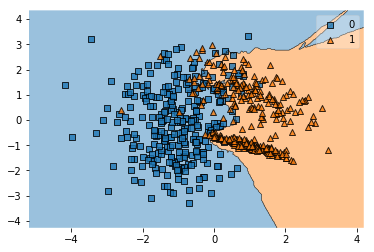

In [58]:
plot_decision_regions(X=test[['x1', 'x2']].values, y=test['y'].values, clf=best_model)

### Investigate Domain changes

In [59]:
test1, test2 = train_test_split(test, test_size=0.5, random_state=42)

In [63]:
ks_2samp(test1['x1'], test2['x1'])

Ks_2sampResult(statistic=0.050000000000000044, pvalue=0.8384236546362508)

In [64]:
ks_2samp(test1['x2'], test2['x2'])

Ks_2sampResult(statistic=0.053333333333333344, pvalue=0.7762428177646631)

In [67]:
svc_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svc', SVC(probability=True, gamma='auto'))
])

In [68]:
svc_pipe.fit(train[['x1', 'x2']], y=train['y'])

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [70]:
score1 = svc_pipe.predict_proba(test1[['x1', 'x2']])[:,1]
score2 = svc_pipe.predict_proba(test2[['x1', 'x2']])[:,1]

In [71]:
ks_2samp(score1, score2)

Ks_2sampResult(statistic=0.053333333333333344, pvalue=0.7762428177646631)

In [73]:
# create experiments
mlflow.create_experiment('svc_ref')

'4'

In [75]:
with open('score_ref.pkl', 'wb') as f:
    dill.dump(score1, f)

In [77]:
mlflow.start_run(experiment_id=4)

<ActiveRun: >

In [78]:
# log artifact
mlflow.log_artifact('score_ref.pkl')

In [83]:
# get artifact
uri = mlflow.get_artifact_uri()
uri

'file:///home/ubuntu/programs/learning/logging/mlruns/4/6383fed8ac074454bb751b8976a125a9/artifacts'

In [93]:
with open('/home/ubuntu/programs/learning/logging/mlruns/4/6383fed8ac074454bb751b8976a125a9/artifacts/score_ref.pkl', 'rb') as f:
    score_ref = dill.load(f)

In [89]:
%%bash
mlflow ui

Process is terminated.


In [95]:
#score_ref

In [96]:
mlflow.end_run()

### roation

In [97]:
# create experiments
mlflow.create_experiment('feature_rotation')

'5'

In [98]:
def rotate(vector, theta=90):
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])
    vector_p = vector @ R.T
    return vector_p

In [105]:
mlflow.end_run()

In [106]:
for angle in np.arange(0,90,1):
    
    # start session
    mlflow.start_run(experiment_id=5)
    
    # log angle
    mlflow.log_param('angle', angle)
    
    # rotate
    test_rot = pd.DataFrame(rotate(test2[['x1', 'x2']].values, theta=angle), columns=['x1', 'x2'])
    
    # metrics: input features
    mlflow.log_param('x1_mean', test_rot['x1'].mean())
    mlflow.log_param('x2_mean', test_rot['x2'].mean())
    
    mlflow.log_param('x1_max', test_rot['x1'].max())
    mlflow.log_param('x2_max', test_rot['x2'].max())
    
    mlflow.log_param('x1_min', test_rot['x1'].min())
    mlflow.log_param('x2_min', test_rot['x2'].min())
    
    mlflow.log_param('x1_std', test_rot['x1'].std())
    mlflow.log_param('x2_std', test_rot['x2'].std())
    
    x1_ks, x1_p = ks_2samp(test1['x1'], test_rot['x1'])
    x2_ks, x2_p = ks_2samp(test1['x2'], test_rot['x2'])
    
    mlflow.log_param('x1_ks', x1_ks)
    mlflow.log_param('x2_ks', x2_ks)
    
    mlflow.log_param('x1_p', x1_p)
    mlflow.log_param('x2_p', x2_p)
    
    # compute preds
    scores_rot = svc_pipe.predict_proba(test_rot[['x1', 'x2']])[:,1]
    
    # metrics: output
    score_ks, score_p = ks_2samp(score_ref, scores_rot)
    mlflow.log_param('scores_ks', score_ks)
    mlflow.log_param('scores_p', score_p)
    
    # metric: feedback
    y_hat = np.where(scores_rot > 0.5, 1, 0)
    y_true = test2['y'].values
    mlflow.log_param('f1', f1_score(y_true, y_hat))
    mlflow.log_param('accuracy', accuracy_score(y_true, y_hat))
    mlflow.log_param('roc_auc_score', roc_auc_score(y_true, scores_rot))

    mlflow.end_run()

In [107]:
test_rot = pd.DataFrame(rotate(test2[['x1', 'x2']].values, theta=20), columns=['x1', 'x2'])

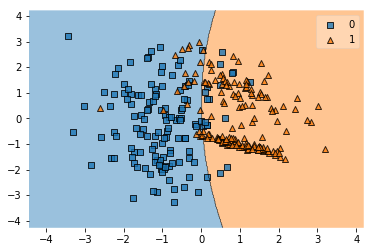

In [112]:
# normal data
plot_decision_regions(X=test2[['x1', 'x2']].values, y=test2['y'].values, clf=svc_pipe)

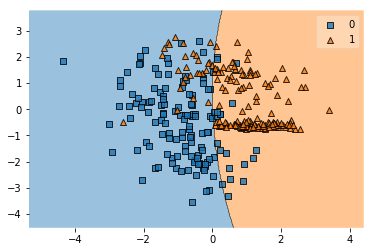

In [111]:
# 20 degree shift
plot_decision_regions(X=test_rot[['x1', 'x2']].values, y=test2['y'].values, clf=svc_pipe)

### translation

In [115]:
# create experiments
mlflow.create_experiment('feature_translation')

'6'

In [126]:
mlflow.end_run()

In [127]:
def translate(vector, a = [0.1,0.1]):
    return vector + a

In [128]:
for element in np.arange(0, 5, 0.1):
    
    # start session
    mlflow.start_run(experiment_id=6)
    
    # log angle
    mlflow.log_param('translation', element)
    
    # translate
    a = np.array([element, element])
    test_rot = test2.apply(lambda x: translate(np.array([x.iloc[0], x.iloc[1]]), a), axis=1, result_type='expand')
    test_rot.columns = ['x1', 'x2']

    # metrics: input features
    mlflow.log_param('x1_mean', test_rot['x1'].mean())
    mlflow.log_param('x2_mean', test_rot['x2'].mean())
    
    mlflow.log_param('x1_max', test_rot['x1'].max())
    mlflow.log_param('x2_max', test_rot['x2'].max())
    
    mlflow.log_param('x1_min', test_rot['x1'].min())
    mlflow.log_param('x2_min', test_rot['x2'].min())
    
    mlflow.log_param('x1_std', test_rot['x1'].std())
    mlflow.log_param('x2_std', test_rot['x2'].std())
    
    x1_ks, x1_p = ks_2samp(test1['x1'], test_rot['x1'])
    x2_ks, x2_p = ks_2samp(test1['x2'], test_rot['x2'])
    
    mlflow.log_param('x1_ks', x1_ks)
    mlflow.log_param('x2_ks', x2_ks)
    
    mlflow.log_param('x1_p', x1_p)
    mlflow.log_param('x2_p', x2_p)
    
    # compute preds
    scores_rot = svc_pipe.predict_proba(test_rot[['x1', 'x2']])[:,1]
    
    # metrics: output
    score_ks, score_p = ks_2samp(score_ref, scores_rot)
    mlflow.log_param('scores_ks', score_ks)
    mlflow.log_param('scores_p', score_p)
    
    # metric: feedback
    y_hat = np.where(scores_rot > 0.5, 1, 0)
    y_true = test2['y'].values
    mlflow.log_param('f1', f1_score(y_true, y_hat))
    mlflow.log_param('accuracy', accuracy_score(y_true, y_hat))
    mlflow.log_param('roc_auc_score', roc_auc_score(y_true, scores_rot))
    
    mlflow.end_run()

In [130]:
test_rot = test2.apply(lambda x: translate(np.array([x.iloc[0], x.iloc[1]]), np.array([0.3,0.3])), axis=1, result_type='expand')
test_rot.columns = ['x1', 'x2']

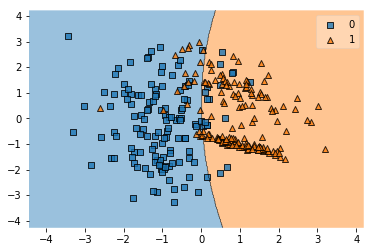

In [131]:
# normal data
plot_decision_regions(X=test2[['x1', 'x2']].values, y=test2['y'].values, clf=svc_pipe)

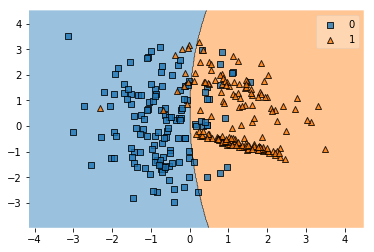

In [132]:
# 20 degree shift
plot_decision_regions(X=test_rot[['x1', 'x2']].values, y=test2['y'].values, clf=svc_pipe)